In [1]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from data.load_data import POST_FIRE_DIR
from src.data_loader.dataset import WildfireDataset
from src.model.unet import UNet
from torch import optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dt = WildfireDataset(POST_FIRE_DIR, transforms=None)

# 80% data for training
n_val_test = int(len(dt) * 0.2)
n_train = len(dt) - n_val_test
train_set, val_test_set = random_split(dt, [n_train, n_val_test], generator=torch.Generator().manual_seed(0))

# 10% data for validating and testing
n_val = int(n_val_test / 2)
n_test = n_val_test - n_val
val_set, test_set = random_split(val_test_set, [n_val, n_test], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=8)
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

In [4]:

model = UNet(n_channels=12, n_classes=1, bilinear=False)
model.to(device=device)

optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

loop = tqdm(n_train)

for i, batch in enumerate(tqdm(train_loader)):
    images, true_masks = batch["image"], batch["mask"]
    
    # reduce img size 
    images = torch.nn.functional.interpolate(images, size=(256,256))
    true_masks = torch.nn.functional.interpolate(true_masks.float(), size=(256,256))
    
    images=images.to(device)
    true_masks = true_masks.to(device=device, dtype=torch.long)
    
    with torch.cuda.amp.autocast():
        predictions = model(images)
        masks_pred = model(images)
        loss = criterion(masks_pred, true_masks.float())
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    
    loop.set_postfix(loss=loss.item())
    

0it [00:00, ?it/s]
0it [00:06, ?it/s, loss=0.693], ?it/s]
0it [00:12, ?it/s, loss=0.69] 5:47,  6.55s/it]
0it [00:18, ?it/s, loss=0.68]05:24,  6.25s/it]
0it [00:24, ?it/s, loss=0.691]5:12,  6.13s/it]
0it [00:30, ?it/s, loss=0.679]5:00,  6.00s/it]
0it [00:36, ?it/s, loss=0.677]4:53,  5.99s/it]
0it [00:42, ?it/s, loss=0.679]4:47,  5.99s/it]
0it [00:48, ?it/s, loss=0.682]4:38,  5.93s/it]
0it [00:54, ?it/s, loss=0.686]4:36,  6.02s/it]
0it [01:00, ?it/s, loss=0.687]4:36,  6.13s/it]
0it [01:06, ?it/s, loss=0.675]04:28,  6.09s/it]
0it [01:13, ?it/s, loss=0.687]04:20,  6.07s/it]
0it [01:19, ?it/s, loss=0.663]04:18,  6.16s/it]
0it [01:25, ?it/s, loss=0.673]04:11,  6.12s/it]
0it [01:31, ?it/s, loss=0.685]04:08,  6.20s/it]
0it [01:37, ?it/s, loss=0.669]04:01,  6.19s/it]
0it [01:43, ?it/s, loss=0.664]03:53,  6.14s/it]
0it [01:49, ?it/s, loss=0.674]03:45,  6.09s/it]
0it [01:55, ?it/s, loss=0.654]03:36,  6.01s/it]
0it [02:01, ?it/s, loss=0.66] 03:32,  6.06s/it]
0it [02:07, ?it/s, loss=0.671]03:25,  6

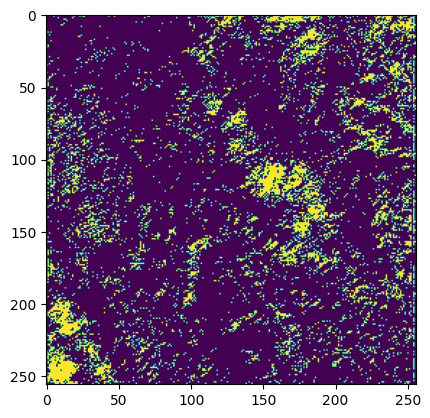

In [9]:
m1 = masks_pred.cpu()[0]
m1 = torch.sigmoid(m1) > 0.6
m1 = m1.long().squeeze().numpy()
plt.imshow(m1)

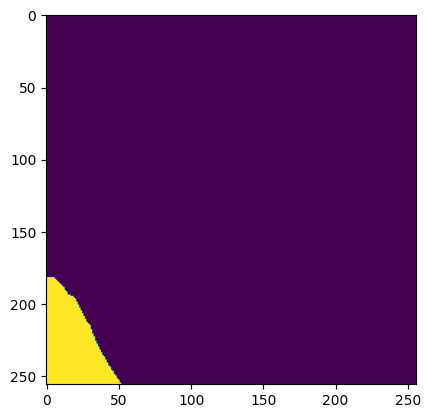

In [10]:
plt.imshow(true_masks.cpu()[0].squeeze().numpy())